In [6]:
import random
random.seed(1)

import numpy as np
np.random.seed(1)

import itertools
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import tensorflow as tf

## Input Data

In [7]:
query_1 = "dog"

bing_search_results = [
    "Dog - Wikipedia",
    "Adopting a dog or puppy | RSPCA Australia",
    "dog | History, Domestication, Physical Traits, & Breeds",
    "New South Wales | Dogs & Puppies | Gumtree Australia Free",
    "dog - Wiktionary"
]

In [8]:
query_2 = "what is a dog"

google_search_results = [
    "Dog - Wikipedia",
    "Dog - Simple English Wikipedia, the free encyclopedia",
    "Dog | National Geographic",
    "dog | History, Domestication, Physical Traits, & Breeds",
    "What is a Dog | Facts About Dogs | DK Find Out"
]

In [9]:
relevance_grades = tf.constant([
    [3.0, 2.0, 2.0, 2.0, 1.0],
    [3.0, 3.0, 1.0, 1.0, 0.0]
])

## Tokenization and Word Embedding

In [10]:
combined_texts = [query_1, *bing_search_results, query_2, *google_search_results]

tokeniser = tf.keras.preprocessing.text.Tokenizer()
tokeniser.fit_on_texts(combined_texts)

# we add one here to account for the padding word
vocab_size = max(tokeniser.index_word) + 1
print(vocab_size)

35


In [11]:
for idx, word in tokeniser.index_word.items():
    print(f"index {idx} - {word}")

index 1 - dog
index 2 - wikipedia
index 3 - a
index 4 - australia
index 5 - history
index 6 - domestication
index 7 - physical
index 8 - traits
index 9 - breeds
index 10 - dogs
index 11 - free
index 12 - what
index 13 - is
index 14 - adopting
index 15 - or
index 16 - puppy
index 17 - rspca
index 18 - new
index 19 - south
index 20 - wales
index 21 - puppies
index 22 - gumtree
index 23 - wiktionary
index 24 - simple
index 25 - english
index 26 - the
index 27 - encyclopedia
index 28 - national
index 29 - geographic
index 30 - facts
index 31 - about
index 32 - dk
index 33 - find
index 34 - out


In [12]:
EMBEDDING_DIMS = 2
embeddings = np.random.randn(vocab_size, EMBEDDING_DIMS).astype(np.float32)
print(embeddings)

[[ 1.6243454  -0.6117564 ]
 [-0.5281718  -1.0729686 ]
 [ 0.86540765 -2.3015387 ]
 [ 1.7448118  -0.7612069 ]
 [ 0.3190391  -0.24937038]
 [ 1.4621079  -2.0601406 ]
 [-0.3224172  -0.38405436]
 [ 1.1337694  -1.0998913 ]
 [-0.1724282  -0.8778584 ]
 [ 0.04221375  0.58281523]
 [-1.1006192   1.1447237 ]
 [ 0.9015907   0.50249434]
 [ 0.90085596 -0.68372786]
 [-0.12289023 -0.93576944]
 [-0.26788807  0.53035545]
 [-0.69166076 -0.39675352]
 [-0.6871727  -0.84520566]
 [-0.6712461  -0.0126646 ]
 [-1.1173104   0.2344157 ]
 [ 1.6598022   0.74204415]
 [-0.19183555 -0.887629  ]
 [-0.7471583   1.6924546 ]
 [ 0.05080776 -0.6369957 ]
 [ 0.19091548  2.1002553 ]
 [ 0.12015896  0.6172031 ]
 [ 0.30017033 -0.35224986]
 [-1.1425182  -0.34934273]
 [-0.20889424  0.5866232 ]
 [ 0.8389834   0.9311021 ]
 [ 0.2855873   0.8851412 ]
 [-0.7543979   1.2528682 ]
 [ 0.5129298  -0.29809284]
 [ 0.48851815 -0.07557172]
 [ 1.1316293   1.5198169 ]
 [ 2.1855755  -1.3964963 ]]


In [13]:
tokeniser.texts_to_sequences([query_1])

[[1]]

In [14]:
query_1_embedding_index = tokeniser.texts_to_sequences([query_1])
query_1_embeddings = np.array([embeddings[x] for x in query_1_embedding_index])
print(query_1_embeddings)

[[[-0.5281718 -1.0729686]]]


In [15]:
query_2_embedding_indices = tokeniser.texts_to_sequences([query_2])
query_2_embeddings = np.array([embeddings[x] for x in query_2_embedding_indices])

print(query_2_embeddings)

[[[ 0.90085596 -0.68372786]
  [-0.12289023 -0.93576944]
  [ 1.7448118  -0.7612069 ]
  [-0.5281718  -1.0729686 ]]]


In [16]:
query_2_embeddings_avg = tf.reduce_mean(query_2_embeddings, axis=1, keepdims=True).numpy()

print(query_2_embeddings_avg)

[[[ 0.49865144 -0.8634182 ]]]


In [17]:
query_embeddings = np.row_stack([query_1_embeddings, query_2_embeddings_avg])
print(query_embeddings.shape)

(2, 1, 2)


In [19]:
docs_sequences = []
for docs_list in [bing_search_results, google_search_results]:
    docs_sequences.append(tokeniser.texts_to_sequences(docs_list))

In [20]:
docs_sequences

[[[1, 2],
  [14, 3, 1, 15, 16, 17, 4],
  [1, 5, 6, 7, 8, 9],
  [18, 19, 20, 10, 21, 22, 4, 11],
  [1, 23]],
 [[1, 2],
  [1, 24, 25, 2, 26, 11, 27],
  [1, 28, 29],
  [1, 5, 6, 7, 8, 9],
  [12, 13, 3, 1, 30, 31, 10, 32, 33, 34]]]

In [22]:
docs_embeddings = []
for docs_set in docs_sequences:
    this_docs_set = []
    for doc in docs_set:
        this_doc_embeddings = np.array([embeddings[idx] for idx in doc])
        this_docs_set.append(this_doc_embeddings)
    docs_embeddings.append(this_docs_set)

In [23]:
# embedding of bing search result
for embeddings in docs_embeddings[0]:
    print()
    print(embeddings)


[[-0.5281718  -1.0729686 ]
 [ 0.86540765 -2.3015387 ]]

[[-0.26788807  0.53035545]
 [ 1.7448118  -0.7612069 ]
 [-0.5281718  -1.0729686 ]
 [-0.69166076 -0.39675352]
 [-0.6871727  -0.84520566]
 [-0.6712461  -0.0126646 ]
 [ 0.3190391  -0.24937038]]

[[-0.5281718  -1.0729686 ]
 [ 1.4621079  -2.0601406 ]
 [-0.3224172  -0.38405436]
 [ 1.1337694  -1.0998913 ]
 [-0.1724282  -0.8778584 ]
 [ 0.04221375  0.58281523]]

[[-1.1173104   0.2344157 ]
 [ 1.6598022   0.74204415]
 [-0.19183555 -0.887629  ]
 [-1.1006192   1.1447237 ]
 [-0.7471583   1.6924546 ]
 [ 0.05080776 -0.6369957 ]
 [ 0.3190391  -0.24937038]
 [ 0.9015907   0.50249434]]

[[-0.5281718  -1.0729686 ]
 [ 0.19091548  2.1002553 ]]


In [24]:
# embedding of google search result
for embeddings in docs_embeddings[1]:
    print()
    print(embeddings)


[[-0.5281718  -1.0729686 ]
 [ 0.86540765 -2.3015387 ]]

[[-0.5281718  -1.0729686 ]
 [ 0.12015896  0.6172031 ]
 [ 0.30017033 -0.35224986]
 [ 0.86540765 -2.3015387 ]
 [-1.1425182  -0.34934273]
 [ 0.9015907   0.50249434]
 [-0.20889424  0.5866232 ]]

[[-0.5281718 -1.0729686]
 [ 0.8389834  0.9311021]
 [ 0.2855873  0.8851412]]

[[-0.5281718  -1.0729686 ]
 [ 1.4621079  -2.0601406 ]
 [-0.3224172  -0.38405436]
 [ 1.1337694  -1.0998913 ]
 [-0.1724282  -0.8778584 ]
 [ 0.04221375  0.58281523]]

[[ 0.90085596 -0.68372786]
 [-0.12289023 -0.93576944]
 [ 1.7448118  -0.7612069 ]
 [-0.5281718  -1.0729686 ]
 [-0.7543979   1.2528682 ]
 [ 0.5129298  -0.29809284]
 [-1.1006192   1.1447237 ]
 [ 0.48851815 -0.07557172]
 [ 1.1316293   1.5198169 ]
 [ 2.1855755  -1.3964963 ]]


In [25]:
# convert each document vector into a fixed-size vector by averaging them along each of their components
# (number of queries, number of documents per query, embedding dimension)
docs_averaged_embeddings = []
for docs_set in docs_embeddings:
    this_docs_set = []
    for doc in docs_set:
        this_docs_set.append(tf.reduce_mean(doc, axis=0, keepdims=True))
    concatenated_docs_set = tf.concat(this_docs_set, axis=0).numpy()
    docs_averaged_embeddings.append(concatenated_docs_set)

docs_averaged_embeddings = np.array(docs_averaged_embeddings)


In [26]:
docs_averaged_embeddings.shape

(2, 5, 2)

In [27]:
NUM_DOCS_PER_QUERY = 5

expanded_queries = tf.gather(query_embeddings, [0 for x in range(NUM_DOCS_PER_QUERY)], axis=1).numpy()

print(expanded_queries)

[[[-0.5281718  -1.0729686 ]
  [-0.5281718  -1.0729686 ]
  [-0.5281718  -1.0729686 ]
  [-0.5281718  -1.0729686 ]
  [-0.5281718  -1.0729686 ]]

 [[ 0.49865144 -0.8634182 ]
  [ 0.49865144 -0.8634182 ]
  [ 0.49865144 -0.8634182 ]
  [ 0.49865144 -0.8634182 ]
  [ 0.49865144 -0.8634182 ]]]


In [28]:
expanded_batch = np.concatenate([expanded_queries, docs_averaged_embeddings], axis=-1)

print(expanded_batch)

[[[-0.5281718  -1.0729686   0.16861793 -1.6872537 ]
  [-0.5281718  -1.0729686  -0.11175551 -0.4011163 ]
  [-0.5281718  -1.0729686   0.269179   -0.81868297]
  [-0.5281718  -1.0729686  -0.02821046  0.31776717]
  [-0.5281718  -1.0729686  -0.16862816  0.5136433 ]]

 [[ 0.49865144 -0.8634182   0.16861793 -1.6872537 ]
  [ 0.49865144 -0.8634182   0.04396335 -0.3385399 ]
  [ 0.49865144 -0.8634182   0.19879965  0.24775822]
  [ 0.49865144 -0.8634182   0.269179   -0.81868297]
  [ 0.49865144 -0.8634182   0.44582415 -0.1306425 ]]]


#### Hidden Layers

In [32]:
dense_1 = tf.keras.layers.Dense(units=3, activation='relu')
dense_1_out = dense_1(expanded_batch)

print(dense_1_out)

tf.Tensor(
[[[0.35279852 1.6670984  0.        ]
  [0.         0.95679986 0.        ]
  [0.         1.2219343  0.        ]
  [0.         0.5883917  0.06972778]
  [0.         0.4685779  0.27151585]]

 [[0.4693008  0.6758069  0.        ]
  [0.         0.         0.        ]
  [0.         0.         0.        ]
  [0.         0.23064291 0.        ]
  [0.         0.         0.        ]]], shape=(2, 5, 3), dtype=float32)


In [33]:
scores = tf.keras.layers.Dense(units=1, activation='linear')
scores_out = scores(dense_1_out)

print(scores_out)

tf.Tensor(
[[[-1.678877  ]
  [-0.8079901 ]
  [-1.0318885 ]
  [-0.4393864 ]
  [-0.17182414]]

 [[-0.9312702 ]
  [ 0.        ]
  [ 0.        ]
  [-0.19477133]
  [ 0.        ]]], shape=(2, 5, 1), dtype=float32)


#### Calculate the KL Divergence in the context of our expanded batch

In [35]:
scores_for_softmax = tf.squeeze(scores_out, axis=-1)
scores_prob_dist = tf.nn.softmax(scores_for_softmax, axis=-1)
print(scores_prob_dist)

tf.Tensor(
[[0.07538026 0.1800856  0.14395978 0.26035237 0.34022197]
 [0.0934422  0.23713113 0.23713113 0.19516434 0.23713113]], shape=(2, 5), dtype=float32)


In [36]:
relevance_grades_prob_dist = tf.nn.softmax(relevance_grades, axis=-1)

print(relevance_grades_prob_dist)

tf.Tensor(
[[0.44663328 0.1643072  0.1643072  0.1643072  0.06044524]
 [0.4309495  0.4309495  0.05832267 0.05832267 0.02145571]], shape=(2, 5), dtype=float32)


In [37]:
loss = tf.keras.losses.KLDivergence()
batch_loss = loss(relevance_grades_prob_dist, scores_prob_dist)

print(batch_loss)

tf.Tensor(0.66682065, shape=(), dtype=float32)


### A toy ListNet Implemenation

In [38]:
NUM_DOCS_PER_QUERY = 5
EMBEDDING_DIMS = 2

In [39]:
class ExpandBatchLayer(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(ExpandBatchLayer, self).__init__(**kwargs)

    def call(self, input):
        queries, docs = input
        batch, num_docs, embedding_dims = tf.unstack(tf.shape(docs))
        expanded_queries = tf.gather(queries, tf.zeros([num_docs], tf.int32), axis=1)
        return tf.concat([expanded_queries, docs], axis=-1)

In [40]:
query_input = tf.keras.layers.Input(shape=(1, EMBEDDING_DIMS, ), dtype=tf.float32, name='query')
docs_input = tf.keras.layers.Input(shape=(NUM_DOCS_PER_QUERY, EMBEDDING_DIMS, ), dtype=tf.float32, name='docs')

expand_batch = ExpandBatchLayer(name="expand_batch")
dense_1 = tf.keras.layers.Dense(units=3, activation='linear', name='dense_1')
dense_out = tf.keras.layers.Dense(units=1, activation='linear', name='scores')
scores_prob_dist = tf.keras.layers.Dense(units=NUM_DOCS_PER_QUERY, activation='softmax', name='score_prob_dist')


expanded_batch = expand_batch([query_input, docs_input])
dense_1_out = dense_1(expanded_batch)
scores = tf.keras.layers.Flatten()(dense_out(dense_1_out))
model_out = scores_prob_dist(scores)

model = tf.keras.models.Model(inputs=[query_input, docs_input], outputs=[model_out])

model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.03, momentum=0.9),
              loss=tf.keras.losses.KLDivergence())

In [41]:
hist = model.fit(
    [query_embeddings, docs_averaged_embeddings],
    relevance_grades_prob_dist,
    epochs=50,
    verbose=False
)

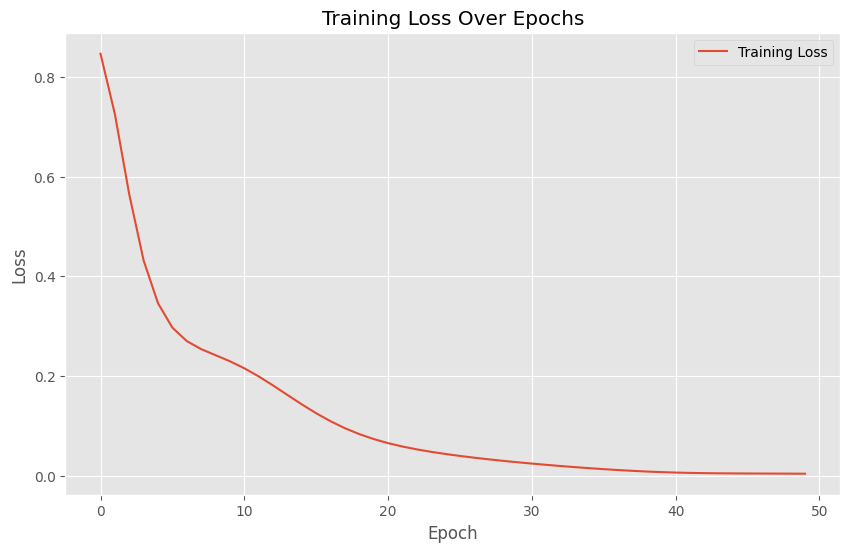

In [42]:
plt.figure(figsize=(10, 6))
plt.plot(hist.history['loss'], label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [45]:
predicted_distribution = model.predict([query_embeddings, docs_averaged_embeddings])
print(predicted_distribution)

1/1 [==============================] - 0s 48ms/step
[[0.4355587  0.15645757 0.16315967 0.15004048 0.09478366]
 [0.4262433  0.43871716 0.05421456 0.06287596 0.01794906]]


In [47]:
relevance_grades_prob_dist = tf.nn.softmax(relevance_grades, axis=-1)
relevance_grades_prob_dist

<tf.Tensor: shape=(2, 5), dtype=float32, numpy=
array([[0.44663328, 0.1643072 , 0.1643072 , 0.1643072 , 0.06044524],
       [0.4309495 , 0.4309495 , 0.05832267, 0.05832267, 0.02145571]],
      dtype=float32)>

In [52]:
import numpy as np
import seaborn as sns

In [62]:
index = 1
predict_dist = predicted_distribution[index]
true_dist = relevance_grades_prob_dist[index]
predict_dist, true_dist

(array([0.4262433 , 0.43871716, 0.05421456, 0.06287596, 0.01794906],
       dtype=float32),
 <tf.Tensor: shape=(5,), dtype=float32, numpy=
 array([0.4309495 , 0.4309495 , 0.05832267, 0.05832267, 0.02145571],
       dtype=float32)>)

In [64]:
predict_dist = predict_dist


In [74]:
def show_distribution(index):
  predict_dist = predicted_distribution[index]
  true_dist = relevance_grades_prob_dist[index]
  true_dist = true_dist.numpy()


  # Create the first bar plot
  plt.figure(figsize=(10, 5))
  plt.subplot(1, 2, 1)
  sns.barplot(x=range(len(true_dist)), y=true_dist)
  plt.title('True Distribution')

  # Create the second bar plot
  plt.subplot(1, 2, 2)
  sns.barplot(x=range(len(predict_dist)), y=predict_dist)
  plt.title('Predicted Distribution')

  # Show the plots
  plt.tight_layout()
  plt.show()

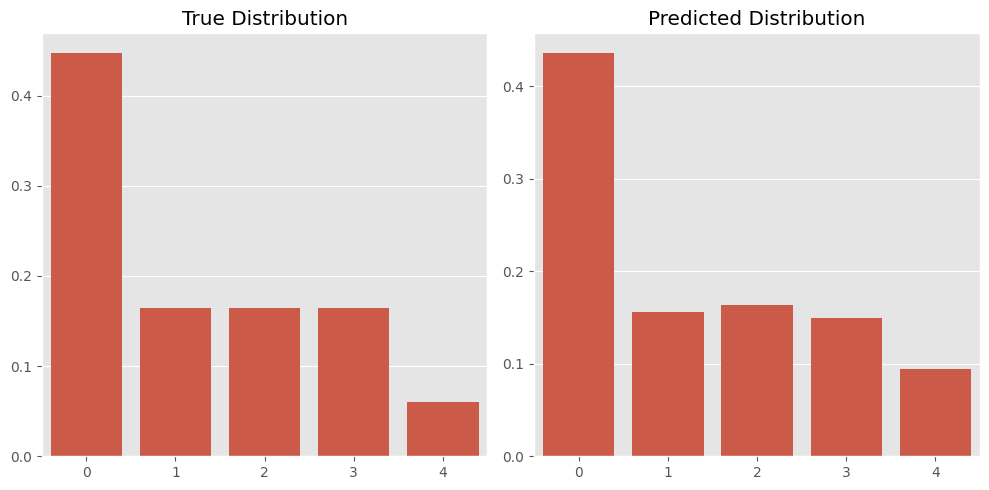

In [75]:
show_distribution(0)

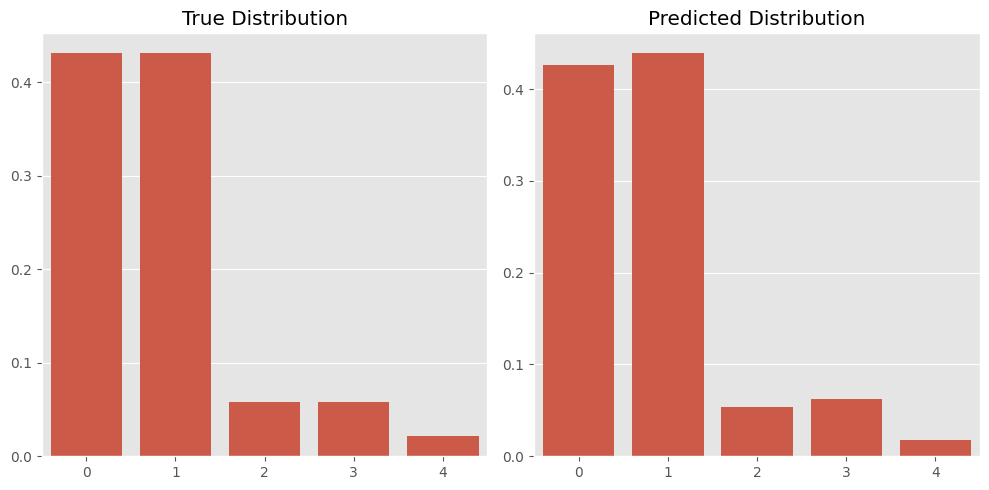

In [76]:
show_distribution(1)